```
# Team
- Rahul Vigneswaran K | CS23MTECH02002
```

# Assignment 2

## Assumption
1. Polytope is non-degenerate.
2. Rak of A is n

Implement the simplex algorithm to maximize the objective function, You need to implement the method discussed in class.

##Input
- CSV file with m+2 rows and n+1 column.
- The first row excluding the last element is the initial feasible point z of length n
- The second row excluding the last element is the cost vector c of length n
- The last column excluding the top two elements is the constraint vector b of length m
- Rows third to m+2 and column one to n is the matrix A of size m*n

##Output
You need to print the sequence of vertices visited and the value of the objective function at that vertex.

# Required Functions


## imports

In [31]:
import csv
import random
import numpy as np
from scipy.linalg import null_space
import numpy as np
from scipy.optimize import linprog
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

## read_data
This function facilitates the reading of a CSV file and retrieves the values stored within columns A, z, b, and c. By default, it utilizes a sample input. If necessary, the function can be uncommented in the main code to enable its functionality.

In [32]:
# reads data from csv
def read_data(filename, initial_point_given = True):
  """
  Reads data from a CSV file and extracts z, c, b, and A matrices.
  """
  with open(filename, newline='') as csvfile:
      reader = csv.reader(csvfile)
      data = list(reader)

  if initial_point_given:
    # Extract z (initial feasible point) and c (cost vector)
    z = np.array([float(val) for val in data[0][:-1]])  # Excluding the last element (empty string)
    c = np.array([float(val) for val in data[1][:-1]])  # Excluding the last element (empty string)

    # Extract b (constraint vector)
    b = np.array([float(row[-1]) for row in data[2:]])  # Last column excluding first two rows

    # Extract A (matrix A)
    A = np.array([[float(val) for val in row[:-1]] for row in data[2:]])  # Excluding the last element (constraint column)

  else:
    # Extract z (initial feasible point) and c (cost vector)
    z = np.array([float(val) for val in data[0][:-1]])  # Excluding the last element (empty string)
    c = np.array([float(val) for val in data[1][:-1]])  # Excluding the last element (empty string)

    # Extract b (constraint vector)
    b = np.array([float(row[-1]) for row in data[2:]])  # Last column excluding first two rows

    # Extract A (matrix A)
    A = np.array([[float(val) for val in row[:-1]] for row in data[2:]])  # Excluding the last element (constraint column)

  return A, z, b, c

## find_tight_rows
This function analyzes the given inputs (A, z, b) to distinguish between tight and untight rows, generating a mask to indicate their classification. It then returns both the identified rows and the corresponding mask for further analysis or processing.

In [33]:
def find_tight_rows(_A, _z, _b, epi=1e-8):
  # the following do multiplication of Z with the corresponding A.
  product = np.dot(_A, _z)

  # Check if the product equals b_i for each row. This will also give us a TRUE/FALSE mask of the tight rows
  tight_mask = np.abs(product - _b) < epi #this is done to prevent rounding errors in 3D cases
  A1 = _A[tight_mask]
  A2 = _A[~tight_mask]
  return tight_mask, A1, A2

## get_directions
This function determines the directional guidance towards the closest vertices. Its calculation involves determining the inverse of -A represented as $-A^{-1}$.

In [34]:
def get_directions(_A1):
  try:
    # Calculate the inverse of matrix A
    A_inv = np.linalg.inv(_A1)

    # Multiply the inverse by -1
    neg_A_inv = -1 * A_inv

    return neg_A_inv

  except np.linalg.LinAlgError:
    # Handling the case where the matrix is singular (non-invertible)
    print("Matrix is singular. Cannot compute the inverse.")
    return None

## feasible_to_vertex_assign2
This function serves to transform an initial feasible point into a vertex through two distinct cases:
- Case 1 : Full Rank Tight Row Matrix:
  - If the tight row matrix is full rank, the initial feasible point is already a vertex.
- Case 2 : Non-Full Rank Tight Row Matrix:
  - To move towards a vertex, a direction and magnitude are essential.
    - Direction ($u$): Computed as a vector from the null space of the tight row matrix. In the absence of tight rows, a random vector of the same shape is utilized.
      - __Handling unbounded case__: If there is no positive $\alpha$, then use $-u$.
    - Magnitude ($\alpha$):
      - $\alpha = \min_{t} \frac{b_t - A_tx_o}{A_t-u}$
      , where $A$ represents the matrix of all non-tight rows.
        - __Handling unbounded case__: If there is no positive $\alpha$, then re-calculate with $-u$.
  - The updated point is computed as: $z_{\text{new}} = z + \alpha u$.
  - This process iterates until the tight rows attain full rank.

In [35]:
import numpy as np

def feasible_to_vertex_assign2(matrix_A, vector_b, vector_z, vector_c, dimension_n):
  # Track variables
  track_cost = []
  track_z = []

  track_cost.append(np.dot(vector_c, vector_z))
  track_z.append(vector_z)

  # Finding rows that satisfy conditions for tight and untight rows
  mask, tight_rows, untight_rows = find_tight_rows(matrix_A, vector_z, vector_b)

  # Calculate rank based on tight rows
  if len(tight_rows) == 0:
    rank = 0
  else:
    rank = np.linalg.matrix_rank(tight_rows)

  # Check if already at a vertex
  if rank == dimension_n:
    print("Already at a vertex!")
    return vector_z, track_z
  else:
    print("Not at a vertex. Searching for a vertex...")

    # Initialize variables for iteration
    z_old = vector_z
    iteration = 0
    print_interval = 1

    # Iterate until reaching a vertex or reaching maximum iterations
    while rank != dimension_n:
      iteration += 1

      # Display iteration information
      if iteration % print_interval == 0:
        print(f"Iteration: {iteration} - Rank: {rank}")

      # Determine direction to move in
      if len(tight_rows) == 0:
        u = np.random.rand(untight_rows.shape[-1])
      else:
        null_space_matrix = null_space(tight_rows)
        u = null_space_matrix[:, 0]

      # Calculate step magnitude
      while True:
        # Calculate step magnitude
        alphas = [(_b_i - np.dot(a2_i, z_old)) / np.dot(a2_i, u) for _b_i, a2_i in zip(vector_b[~mask], untight_rows)]
        all_alphas = [alpha for alpha in alphas if alpha > 0]
        if len(all_alphas) == 0:  #handling unbounded case
          u = -1*u
        else:
          break

      alpha = min(all_alphas)

      # Move to the new vertex
      z_new = z_old + alpha * u

      # Update tight and untight rows based on the new vertex
      mask, tight_rows, untight_rows = find_tight_rows(matrix_A, z_new, vector_b)
      z_old = z_new

      # Recalculate rank based on updated tight rows
      if len(tight_rows) == 0:
        rank = 0
      else:
        rank = np.linalg.matrix_rank(tight_rows)

      # Store the newly found vertex
      track_cost.append(np.dot(vector_c, z_new))
      track_z.append(z_new)

    print(f"Vertex found! - Rank: {rank}")
    return z_new, track_cost, track_z


## vertex_to_vertex_assign2
This function employs Vertex Marching to search for the maximum optimal vertex based on a given vertex. The process involves using all tight rows represented by $A$ to calculate $-A^{-1}$, where each column in the resulting matrix signifies a direction to the nearest vertex.

- Case 1: Check for Optimality:
    - We take the columns of $-A^{-1}$, denoted as $u$, and assess whether the dot product of $u$ and $c$ is positive. If none of the columns' dot products are positive:
      - The current vertex stands as the optimal vertex.
- Case 2: Move towards a Vertex:
  - When a positive direction exists among the columns of $-A^{-1}$ (represented as $u$ and checked against $c$):
    - To proceed towards a vertex, determining direction and magnitude is necessary.
      - Direction ($u$): This is same as the previously identified positive direction.
      - Magnitude ($\alpha$):
        - $\alpha = \min_{t} \frac{b_t - A_tx_o}{A_t - u}$. Here, $A$ refers to the matrix of all non-tight rows.
          - __Handling unbounded case__: If there is no positive $\alpha$, that means the problem is unbounded. In this case, we just return the vertices we have visited so far with corresponding cost and print that the problem is unbounded.
    - Update the point as: $z_{\text{new}} = z + \alpha u$.
    - Iterate this process until no positive directions remain.

In [36]:
import numpy as np

def vertex_to_vertex_assign2(matrix_A, vector_b, vector_z, vector_c, columns):
  # Track variables
  track_cost = []
  track_vertex = []

  # Initialize variables
  z_old = vector_z
  z_new = z_old
  track_cost.append(np.dot(vector_c, z_old))
  track_vertex.append(z_old)
  iteration = 0
  print_interval = 1

  while True:
    iteration += 1
    # Display iteration information
    if iteration % print_interval == 0:
      print(f"Iteration: {iteration}")

    # Find tight and untight rows
    mask, tight_rows, untight_rows = find_tight_rows(matrix_A, z_old, vector_b)

    # Get directions
    directions = get_directions(tight_rows).T

    # Get positive directions to move in
    positive_directions = []
    for direction in directions:
      if np.dot(direction, vector_c) > 0:
        positive_directions.append(direction)

    if not positive_directions:
      print("Reached the optimal vertex!")
      return z_new, track_cost, track_vertex

    u = positive_directions[0]  # Select a positive direction

    # Calculate step size
    alphas = [(b_i - np.dot(a2_i, z_old)) / np.dot(a2_i, u) for b_i, a2_i in zip(vector_b[~mask], untight_rows)]
    positive_alphas = [alpha for alpha in alphas if alpha > 0]

    if len(positive_alphas) == 0 : # Handling unbounded case
      print(f"The problem is unbounded. Can't find a optimal solution!")
      return None, track_cost, track_vertex

    alpha = min(positive_alphas)

    z_new = z_old + alpha * u
    z_old = z_new

    # Calculate cost of current vertex
    track_cost.append(np.dot(vector_c, z_new))
    track_vertex.append(z_new)

# Main
## Sample test cases
- `testcase_1.csv` : With initial feasible point, Non-degenerate, Bounded. https://www.desmos.com/calculator/3pscsowphb

- `testcase_2.csv` : With initial feasible point, Non-degenerate, Unbounded. https://www.desmos.com/calculator/mgfg9jhofq

| Test Case 1 | Test Case 2 |
|-------------|-------------|
|    PASS     |    PASS     |

## Reading the input

In [37]:
A, z, b, c = read_data('testcase_2.csv', initial_point_given=True)

m, n = len(b), len(c)

# Display extracted data
print("Initial Feasible Point (z):", z)
print("Cost Vector (c):", c)
print("Constraint Vector (b):", b)
print("Matrix A:")
print(A)
print(f"Rows: {m} | Columns: {n}")

Initial Feasible Point (z): [20. 20.]
Cost Vector (c): [5. 2.]
Constraint Vector (b): [1. 1. 1.]
Matrix A:
[[ 0. -1.]
 [-1.  0.]
 [-1. -1.]]
Rows: 3 | Columns: 2


## Feasible point to vertex
- `z_new`: The initial vertex from which we will start vertex marching.
- `z_all`: Has all the `z` we visited. The last element is the inital vertex from which we will start vertex marching.
- `z_cost`: Has all the costs corresponding to the `z` in `z_all`.

In [38]:
# feasible point to vertex
z_new, z_cost_all, z_all = feasible_to_vertex_assign2(A, b, z, c, n)

Not at a vertex. Searching for a vertex...
Iteration: 1 - Rank: 0
Iteration: 2 - Rank: 1
Vertex found! - Rank: 2


In [39]:
print(z_new)
print(z_all)
print(z_cost_all)

[ 0. -1.]
[array([20., 20.]), array([ 1.37036611, -1.        ]), array([ 0., -1.])]
[140.0, 4.851830527903449, -2.0]


### Visualizing the feasible point to vertex journey
> WARNING: Skip this if the input is very large as it involves TSNE and that might take a long time for such inputs.

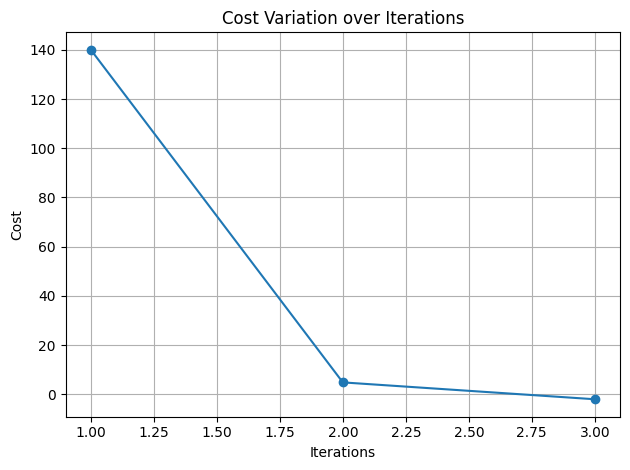

In [40]:
# Plotting the costs against iterations
iterations = range(1, len(z_cost_all) + 1)
plt.plot(iterations, z_cost_all, marker='o')

# Adding labels and title
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Cost Variation over Iterations')

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()

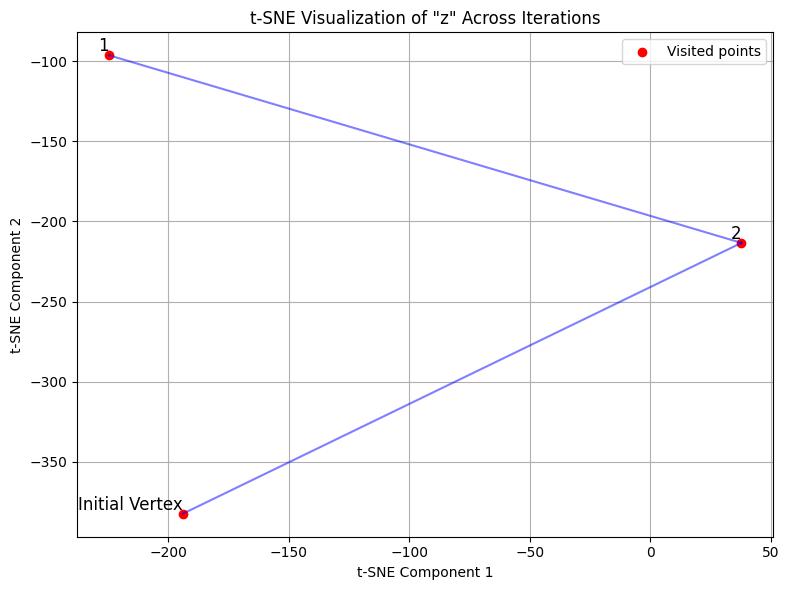

In [41]:
vectors = np.stack(z_all)

if len(vectors) > 1:

  # Perform t-SNE to reduce the vectors to a 2-dimensional space
  tsne = TSNE(n_components=2, random_state=42, perplexity=len(vectors) - 1)
  vectors_2d = tsne.fit_transform(vectors)

  # Plot the vectors in the 2D t-SNE space and connect them across iterations
  plt.figure(figsize=(8, 6))
  for i in range(len(vectors_2d) - 1):
      plt.plot(
          [vectors_2d[i][0], vectors_2d[i + 1][0]],
          [vectors_2d[i][1], vectors_2d[i + 1][1]],
          'b-',
          alpha=0.5
      )
      plt.scatter(vectors_2d[i][0], vectors_2d[i][1], color='red')
      plt.text(
          vectors_2d[i][0],
          vectors_2d[i][1],
          str(i + 1),
          horizontalalignment='right',
          verticalalignment='bottom',
          fontsize=12,
          color='black'
      )

  # Plot the last vector separately to avoid connecting it to the next iteration
  plt.scatter(vectors_2d[-1][0], vectors_2d[-1][1], color='red', label='Visited points')
  plt.text(
      vectors_2d[-1][0],
      vectors_2d[-1][1],
      "Initial Vertex",
      horizontalalignment='right',
      verticalalignment='bottom',
      fontsize=12,
      color='black'
  )

  # Set labels and title
  plt.xlabel('t-SNE Component 1')
  plt.ylabel('t-SNE Component 2')
  plt.title('t-SNE Visualization of "z" Across Iterations')
  plt.legend()
  plt.grid(True)
  plt.tight_layout()

  # Show the plot
  plt.show()
else:
  print("Cant plot TSNE as there is only one vector!")

## Vertex to Optimal Vertex
- `z_optimal`: The final optimal vertex.
- `z_all`: Has all the `z` we visited. The last element is the optimal vertex.
- `z_cost`: Has all the costs corresponding to the `z` in `z_all`.

In [42]:
# vertex marching
z_optimal, z_cost_all, z_all = vertex_to_vertex_assign2(A, b, z_new, c, n)

Iteration: 1
The problem is unbounded. Can't find a optimal solution!


In [43]:
if np.all(z_optimal == None):
  print("The problem is unbounded!")

print(z_optimal)
print(z_all)
print(z_cost_all)

The problem is unbounded!
None
[array([ 0., -1.])]
[-2.0]


### Visualizing the vertex to optimal vertex path
> WARNING: Skip this if the input is very large as it involves TSNE and that might take a long time for such inputs.

The problem is unbounded!


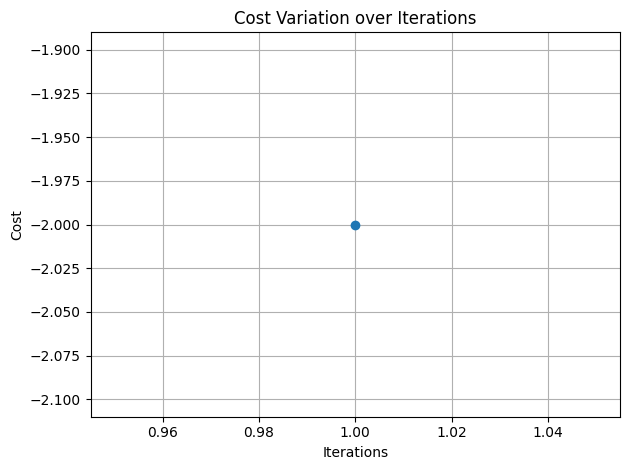

In [44]:
if np.all(z_optimal == None):
  print("The problem is unbounded!")

# Plotting the costs against iterations
iterations = range(1, len(z_cost_all) + 1)
plt.plot(iterations, z_cost_all, marker='o')

# Adding labels and title
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Cost Variation over Iterations')

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()


In [45]:
if np.all(z_optimal == None):
  print("The problem is unbounded!")
  final_point = "Vertex"
else:
  final_point = "Optimal Vertex"

vectors = np.stack(z_all)
if len(vectors) > 1:
  # Perform t-SNE to reduce the vectors to a 2-dimensional space
  tsne = TSNE(n_components=2, random_state=42, perplexity=len(vectors) - 1)
  vectors_2d = tsne.fit_transform(vectors)

  # Plot the vectors in the 2D t-SNE space and connect them across iterations
  plt.figure(figsize=(8, 6))
  for i in range(len(vectors_2d) - 1):
      plt.plot(
          [vectors_2d[i][0], vectors_2d[i + 1][0]],
          [vectors_2d[i][1], vectors_2d[i + 1][1]],
          'b-',
          alpha=0.5
      )
      plt.scatter(vectors_2d[i][0], vectors_2d[i][1], color='red')
      plt.text(
          vectors_2d[i][0],
          vectors_2d[i][1],
          str(i + 1),
          horizontalalignment='right',
          verticalalignment='bottom',
          fontsize=12,
          color='black'
      )

  # Plot the last vector separately to avoid connecting it to the next iteration
  plt.scatter(vectors_2d[-1][0], vectors_2d[-1][1], color='red', label='Visited Vertex')
  plt.text(
      vectors_2d[-1][0],
      vectors_2d[-1][1],
      final_point,
      horizontalalignment='right',
      verticalalignment='bottom',
      fontsize=12,
      color='black'
  )

  # Set labels and title
  plt.xlabel('t-SNE Component 1')
  plt.ylabel('t-SNE Component 2')
  plt.title('t-SNE Visualization of Vertices Across Iterations')
  plt.legend()
  plt.grid(True)
  plt.tight_layout()

  # Show the plot
  plt.show()
else:
  print("Cant plot TSNE as there is only one vector!")

The problem is unbounded!
Cant plot TSNE as there is only one vector!
